# Dividir Clips de Audio 

Este documento es para describir una estrategia para poder aislar los mensajes de audio recibidos mediante una frecuencia de radio especifica. <mark>Separandolos en pistas de audio independientes</mark> para luego ser analizados y procesados en un programa de transcripción de audio. 

### Consideraciones

La señal de radio de entrada pasa por multiples filtros antes y después de ser demodulada a audio, todos con el objetivo de recuperar la señal sin importar la fuerza e intensidad con la que se recibe el mensaje. Sobre simplificando:

**Señal de entrada -----[Transformación y recepción]-----[<mark>Demodulación</mark> (De señal a audio)]-----[<mark>Amplificación de salida</mark>]----- Parlante**

Dos puntos claves para este proceso están en la Demodulación y la Amplificación de salida. 

IMPORTANTE: Con el objetivo de escuchar solo mensajes y no constantemente ruido blanco las radios implementan un filtro <mark>Squelch</mark> que es un termino especial para referirse a mutear el audio cuando la señal de entrada esta por debajo de un threshold (aveces regulable). 

Por otra parte la señal <mark>a la salida se regula su ganancia</mark> para que señales de baja intensidad suenen a un mismo nivel. Es por esto que al trabajar en separar los clips de audio si nuestro Squelch deja pasar ruido blanco se escuchara con la misma intensidad que las señales de voz causando que sea más difícil de filtrar.

Todo esto para decir que el proceso de dividir los clips de audio depende de que el filtro Squelch cumpla con su objetivo.

no mas distracciones, a lo que vamos

In [14]:
# Dependencias
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import wave
import librosa, librosa.display
import sys
import os
import soundfile as sf
import sounddevice as sd

# Redirect stderr to /dev/null to suppress ALSA warnings
sys.stderr = open(os.devnull, 'w')

In [24]:
# Funciones 

def plot_waveform_segments(y, sr, segments, title='Waveform', xlabel='Time (s)', ylabel='Amplitude'):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    for segment in segments:
        plt.axvspan(segment[0], segment[1], color='green', alpha=0.5)

    plt.tight_layout()
    plt.show()

def plot_rms_segments(times, rms, threshold, segments, title='RMS Energy', xlabel='Time (s)', ylabel='RMS Energy'):
    plt.figure(figsize=(14, 5))
    plt.plot(times, rms, label='RMS Energy')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Auto-adjusted Threshold')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    for segment in segments:
        plt.axvspan(segment[0], segment[1], color='green', alpha=0.5)

    plt.tight_layout()
    plt.show()

### Escuchar una Entrada de Audio
En teoría un PC puede tener multiples entradas de audio ya sea si vienen de la interfaz RTL-SDR o del micrófono de una tarjeta de audio, debemos poder escuchar en tiempo real lo que suena en ella en paralelo a nuestro programa.

Comenzamos por identificar cual es nuestra entrada de audio...

In [6]:
p = pyaudio.PyAudio()

for i in range(p.get_device_count()):
    print(p.get_device_info_by_index(i)['index'], p.get_device_info_by_index(i)['name'])
p.terminate()
# Hide alsa warnings

0 sof-hda-dsp: - (hw:0,0)
1 sof-hda-dsp: - (hw:0,3)
2 sof-hda-dsp: - (hw:0,4)
3 sof-hda-dsp: - (hw:0,5)
4 sof-hda-dsp: - (hw:0,6)
5 sof-hda-dsp: - (hw:0,7)
6 sysdefault
7 samplerate
8 speexrate
9 jack
10 pipewire
11 pulse
12 upmix
13 vdownmix
14 dmix
15 default
16 Cannon Point-LP High Definition Audio Controller Digital Microphone
17 Cannon Point-LP High Definition Audio Controller Headphones Stereo Microphone
18 Cannon Point-LP High Definition Audio Controller Speaker + Headphones
19 Cannon Point-LP High Definition Audio Controller HDMI / DisplayPort 1 Output
20 Cannon Point-LP High Definition Audio Controller HDMI / DisplayPort 2 Output
21 Cannon Point-LP High Definition Audio Controller HDMI / DisplayPort 3 Output


Para este notebook grabamos o abrimos una pista de audio de prueba

In [7]:
# Parameters
CHUNK = 1024  # Number of audio samples per frame
FORMAT = pyaudio.paInt16  # Audio format (16-bit PCM)
CHANNELS = 1  # Mono audio
RATE = 44100  # Sample rate (samples per second)
WAVE_OUTPUT_FILENAME = "recording.wav"

In [17]:
RECORD_SECONDS = 20

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK, 
                input_device_index=15)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


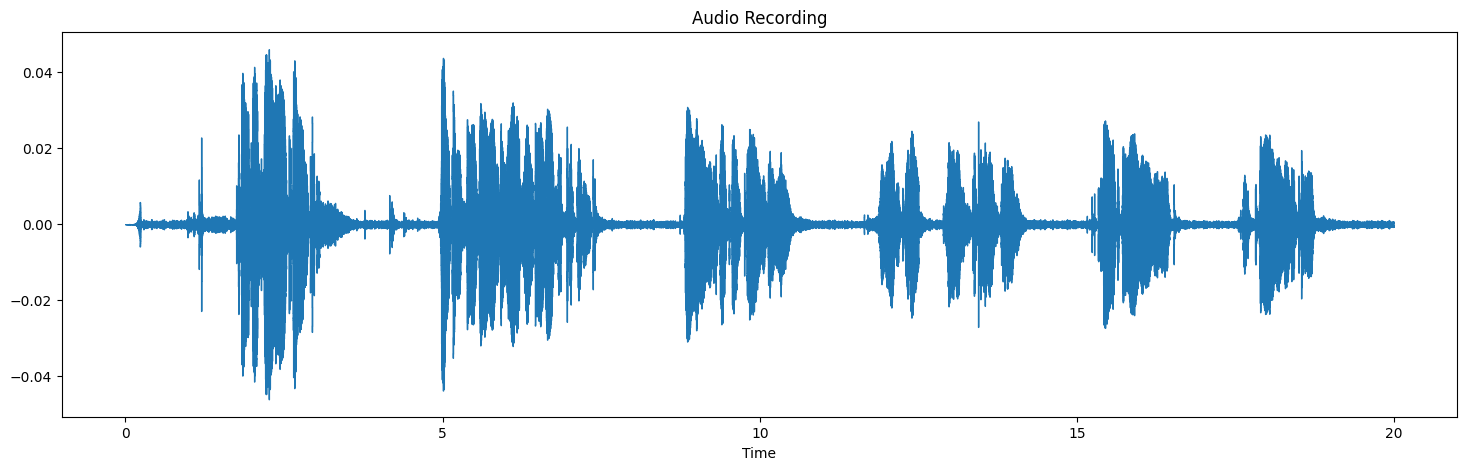

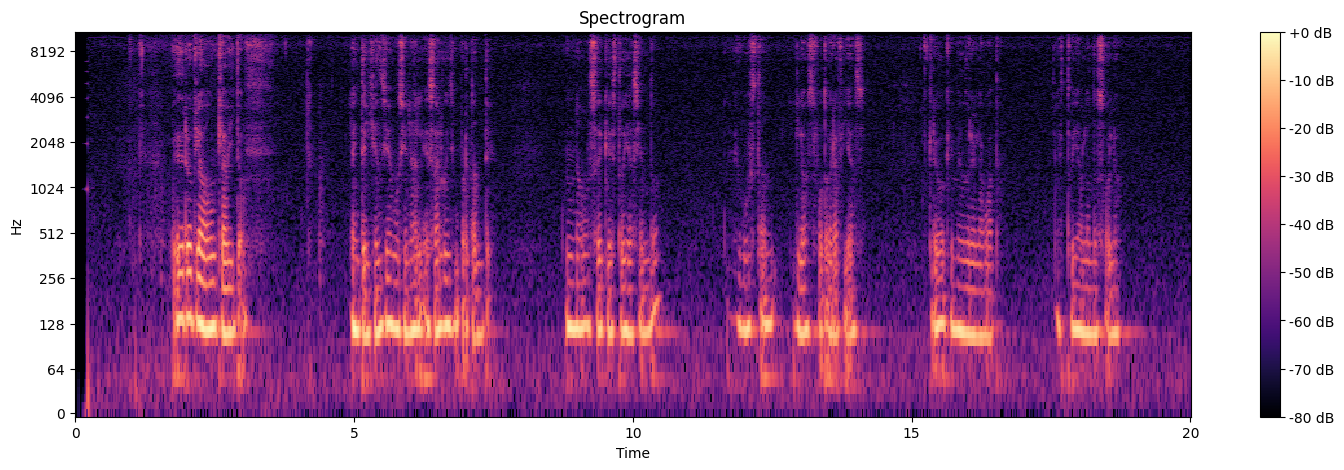

In [18]:
# Display the audio file
y, sr = librosa.load(WAVE_OUTPUT_FILENAME)

plt.figure(figsize=(18, 5))
plt.title('Audio Recording')
librosa.display.waveshow(y, sr=sr)
plt.show()

# Display the spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(18, 5))
plt.title('Spectrogram')
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

### Medir la intensidad RMS de la señal y separar con un threshold

RMS = Root Mean Square es una representación de la energía promedio de la señal en un intervalo de tiempo, nos sirve para ver en que partes de la señal existe mayor variabilidad (donde hay voces en nuestro caso).

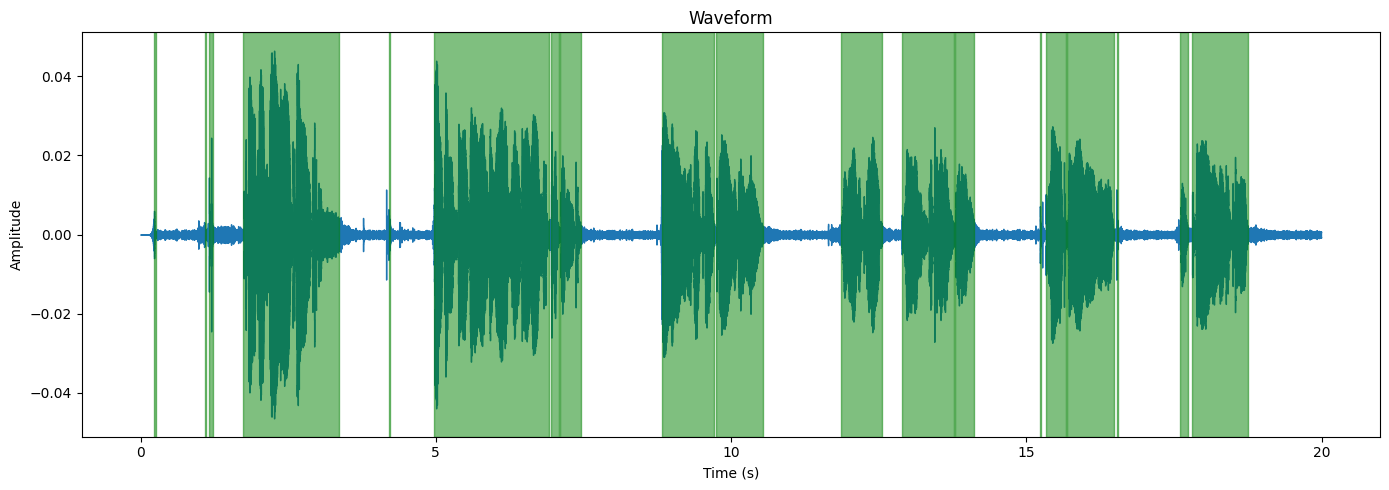

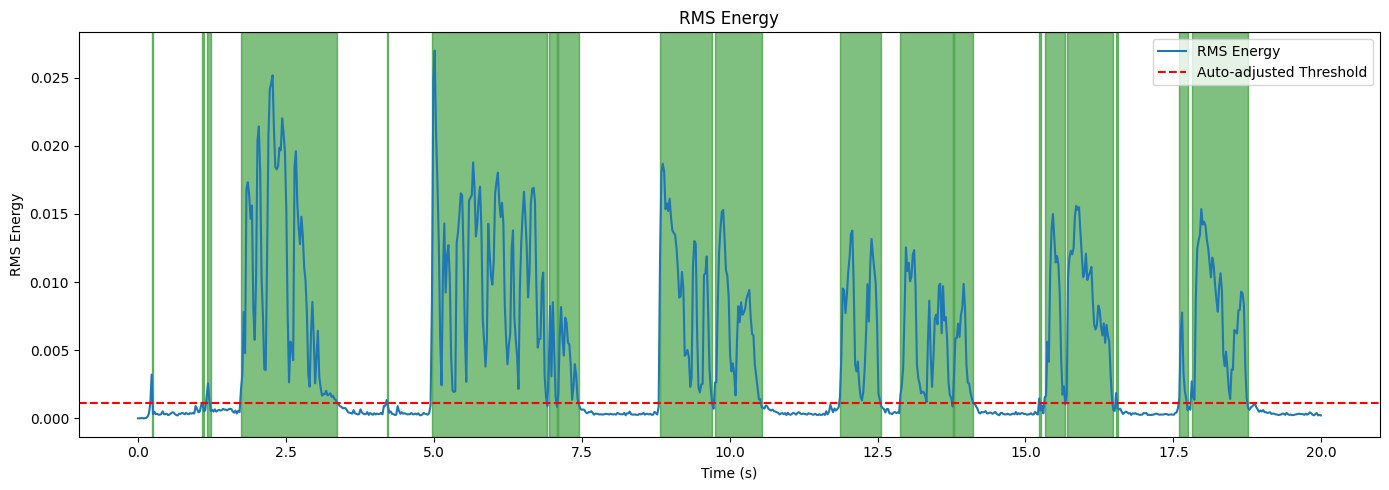

In [19]:
THRESHOLD_FACTOR = 0.2

# Load the audio file
y, sr = librosa.load(WAVE_OUTPUT_FILENAME, sr=RATE)

# Compute the RMS (root mean square) of the audio signal in frames
rms = librosa.feature.rms(y=y, frame_length=CHUNK, hop_length=CHUNK, center=True)[0]

# Get the minimum, and standard deviation of the RMS signal
min_rms = np.min(rms)
std_rms = np.std(rms)

# Auto-adjust threshold based on minimum RMS and standard deviation
threshold = min_rms + THRESHOLD_FACTOR * std_rms

# Time vector for the RMS signal
times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=CHUNK)

# Identify segments above the threshold
above_threshold_segments = []
start_time = None

for i in range(len(rms)):
    if rms[i] > threshold and start_time is None:
        start_time = times[i]
    elif rms[i] <= threshold and start_time is not None:
        end_time = times[i]
        above_threshold_segments.append((start_time, end_time))
        start_time = None

# Handle case where the last segment is above the threshold until the end
if start_time is not None:
    above_threshold_segments.append((start_time, times[-1]))

plot_waveform_segments(y, sr, above_threshold_segments)
plot_rms_segments(times, rms, threshold, above_threshold_segments)

### Unir los Segmentos Contiguos y Filtrar los Segmentos Cortos (El orden de los factores importa)

Considerando las pausas de un mensaje debemos <mark>unir</mark> los segmentos que presenten pausas muy cortas y luego <mark>eliminar los segmentos muy cortos</mark> (qué probablemente no aportan información). Luego damos un margen de error agregando un <mark>pad de tiempo</mark> al inicio y el final del cada mensaje.

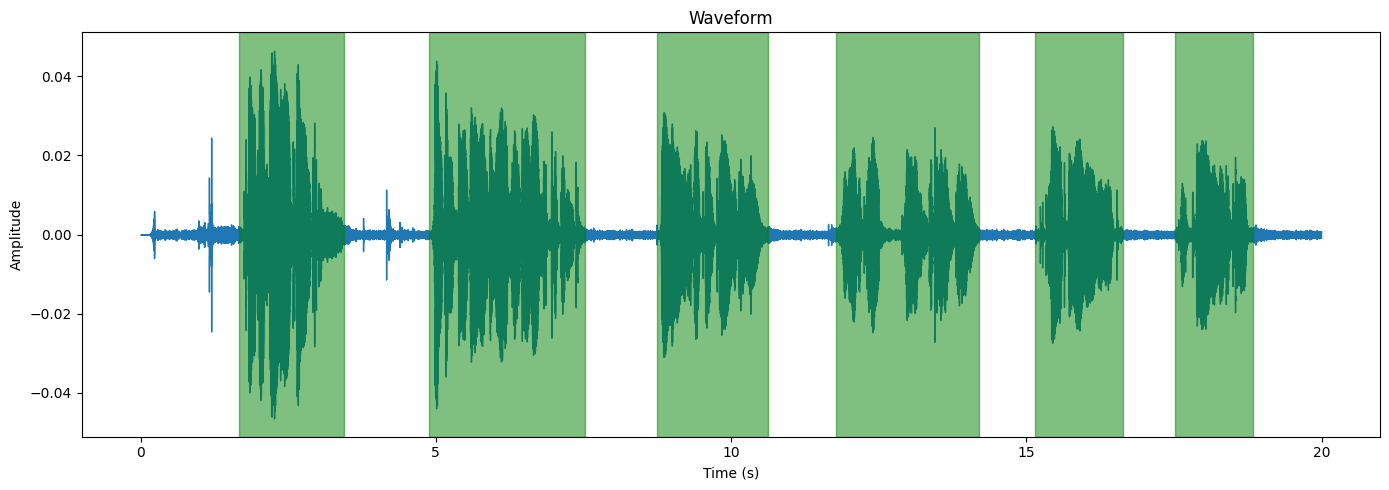

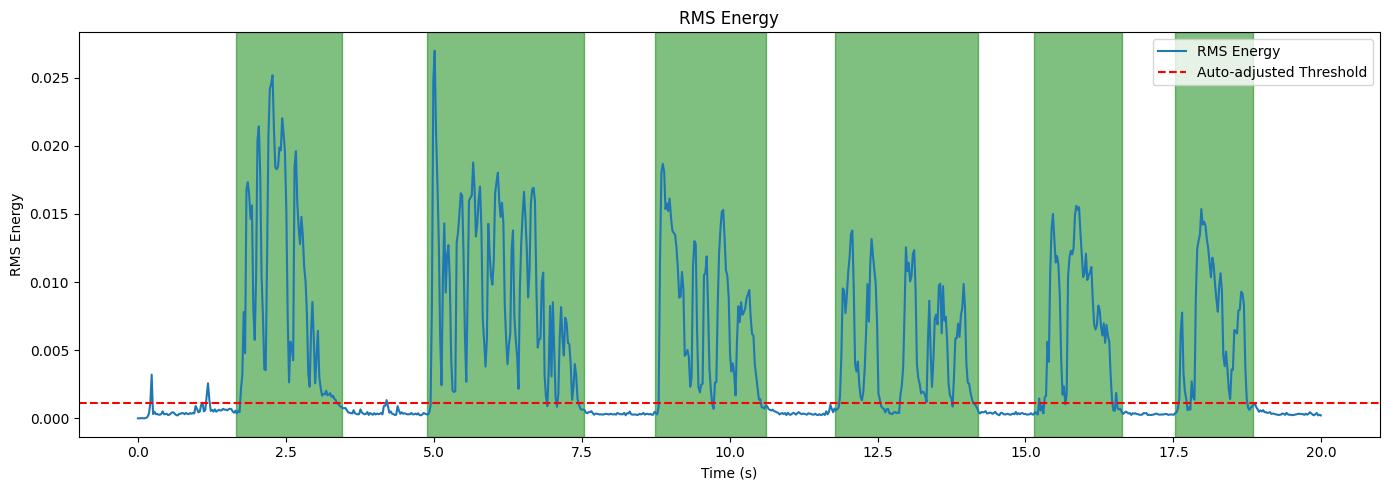

In [25]:
# join and filter segments
MIN_SEGMENT_DURATION = 0.5
MIN_SEGMENT_DISTANCE = 0.5
SEGMENT_PADDING = 0.08

filtered_segments = []

# Join segments that are too close to each other
for i in range(len(above_threshold_segments)):
    if i == 0:
        filtered_segments.append(above_threshold_segments[i])
    else:
        if above_threshold_segments[i][0] - filtered_segments[-1][1] < MIN_SEGMENT_DISTANCE:
            filtered_segments[-1] = (filtered_segments[-1][0], above_threshold_segments[i][1])
        else:
            filtered_segments.append(above_threshold_segments[i])

# Filter segments that are too short
filtered_segments = [segment for segment in filtered_segments if segment[1] - segment[0] > MIN_SEGMENT_DURATION]

# Add padding to the segments
filtered_segments = [(max(0, segment[0] - SEGMENT_PADDING), min(times[-1], segment[1] + SEGMENT_PADDING)) for segment in filtered_segments]


plot_waveform_segments(y, sr, filtered_segments)
plot_rms_segments(times, rms, threshold, filtered_segments)

### Grabar los Clips de Audio
Para cada segmento se graba un clip de audio por separado

In [26]:
clips = []

for i, segment in enumerate(filtered_segments):
    start_sample = int(segment[0] * sr)
    end_sample = int(segment[1] * sr)
    clip = y[start_sample:end_sample]
    clips.append(clip)
    sf.write(f'clip_{i}.wav', clip, sr)


In [27]:
# Play the audio clips using the soundfile library
for i, clip in enumerate(clips):
    print(f'Playing clip {i}...')
    sd.play(clip, sr)
    sd.wait()  # Wait until the audio is finished playing
    print('Press any key to continue...')
    input()

Playing clip 0...
Press any key to continue...
Playing clip 1...
Press any key to continue...
Playing clip 2...
Press any key to continue...
Playing clip 3...
Press any key to continue...
Playing clip 4...
Press any key to continue...
Playing clip 5...
Press any key to continue...


### Utilidades

In [28]:
# Si queremos eliminar los clips creados
# NUM_CLIPS = 3
NUM_CLIPS = len(clips)

for i in range(NUM_CLIPS):
    os.remove(f'clip_{i}.wav') 